# Problem Set: Solar Power Generation Data - examined by Andreas Eppler

# 1. Problem definition: short term solar power generation forecasting
Data taken from: https://www.kaggle.com/anikannal/solar-power-generation-data?select=Plant_2_Weather_Sensor_Data.csv <br>
The data of the problem set has been gathered at two solar power plants located in India. The data covers a 34 day period. It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. The power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at the plant level with a single array of sensors optimally placed at the plant.

There are a few areas of concern at the solar power plant -

1. Can we predict the power generation for next couple of days? - this allows for better grid management
2. Can we identify the need for panel cleaning/maintenance?
3. Can we identify faulty or suboptimally performing equipment?

I consider the first task to be the most important issue to investigate as in the coming years, the energy grid will be very dynamically regulated. Being able to forecast renewable energy production for the next couple of days will be a huge help to regulate the grid via storage solutions such as pumped-storage power plants and electric cars with bidirectional charging capability. This will allow to enable a stable, prosumer driven grid. <br>
The second and third tasks play an important role in ensuring the highest possible profitability of the solar power plant, which is important for the operating company. However, it plays a smaller role in the viability of the energy transition and will therefore not be investigated in the scope of this project

In [290]:
from IPython.display import Image
Image(url="solar_power_plant.svg", width = 700)

time: 0 ns (started: 2022-03-04 13:24:10 +01:00)


### 1.1 working principle of a solar power plant
The self-created image shows the basic build of a solar power plant. Rows of modules are wired together and then connected to an inverter, that transforms the DC current to an AC current in order to feed the energy into the electric grid. The single modules can either be wired together with a parallel or series connection (as shown in the above image). 
There are advantages and disadvantages to both the interconnection options.
- In a series connection, the current stays the same while the voltage is increased with each module. This allows for easy wiring. However, if only one of the modules is faulty or produces a lower current due to shading, the current and with that, the power of the whole installation decreases. 
- With a parallel connection, the voltage remeains persistent while the current of the modules is added up. With it, shading and faulty modules are less of a problem. However, faulty modules are also harder to detect. Due to the larger currents, the wiring requires more effort and is more expensive.

source: https://www.solaranlage.eu/photovoltaik/technik-komponenten/wechselrichter/konzepte-zur-verschaltung

#### 1.2 Choosing a measure of Loss/Success:

In [291]:
#TODO Working hypothesis: chose a measure of loss / success: MSE, MAE, MAPE, R² score

time: 0 ns (started: 2022-03-04 13:24:10 +01:00)


#### 1.3 Customizing the evaluation protocol

In [292]:
#TODO: How much Data spared for testing? How much for validation?

time: 0 ns (started: 2022-03-04 13:24:10 +01:00)


# 2. Data exploration and Preparation

In [293]:
%pip install ipython-autotime
%load_ext autotime

Note: you may need to restart the kernel to use updated packages.
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.23 s (started: 2022-03-04 13:24:10 +01:00)


You should consider upgrading via the 'C:\Users\AEppl\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [294]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 0 ns (started: 2022-03-04 13:24:13 +01:00)


In the following, for the sake of improved clarity, only the second solar power plant is being investigated. However, provided underneath is the option to switch to the first power plant for reasons of boundless curiosity.

In [295]:
# plant_no = 2
plant_no = 1

time: 0 ns (started: 2022-03-04 13:24:13 +01:00)


In [296]:
gen_data = pd.read_csv(f'Plant_{plant_no}_Generation_Data.csv')
gen_data

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0
...,...,...,...,...,...,...,...
68773,17-06-2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,17-06-2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,17-06-2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,17-06-2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0


time: 140 ms (started: 2022-03-04 13:24:13 +01:00)


There are seven columns for both the data sets consisting of the plant id (same for the entire dataset), the id of each inverter (source_key), AC- and DC-power, daily yield and total yield. From kaggle, we take the following information:
1. DATE_TIME:   Date and time for each observation. Observations recorded at 15 minute intervals.
2. PLANT_ID:    Plant ID - this will be common for the entire file. --> can therefore be deleted
3. SOURCE_KEY:  Source key in this file stands for the inverter id.
4. DC_POWER:    Amount of DC power generated by the modules connected to one inverter (source_key) in this 15 minute interval. Units - kW.
5. AC_POWER:    Amount of AC power after conversion by the inverter (source_key) in this 15 minute interval. Units - kW.
6. DAILY_YIELD: Daily yield is a cumulative sum of power generated on that day, till that point in time.
7. TOTAL_YIELD: This is the total yield for the inverter till that point in time.

In [297]:
weather_data = pd.read_csv(f'Plant_{plant_no}_Weather_Sensor_Data.csv')
weather_data

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0
...,...,...,...,...,...,...
3177,2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
3178,2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
3179,2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0
3180,2020-06-17 23:30:00,4135001,HmiyD2TTLFNqkNe,21.969495,20.734963,0.0


time: 47 ms (started: 2022-03-04 13:24:13 +01:00)


In [298]:
weather_data["SOURCE_KEY"][0] in gen_data["SOURCE_KEY"]

False

time: 0 ns (started: 2022-03-04 13:24:13 +01:00)


We can see that the weather data covers the same period of time and is taken at the same plant (similar plant id). The data covers the ambient temperature, module temperature and the irradiation, which will be really helpful for time series prediction. 
Irradiation and with this the number of photons is directly linked to the energy output of the solar panels while the temperature of a solar module changes the efficiency of the modules. As a general rule, the efficiency of a solar panel declines with increasing temperatures. 
Unfortunately, as checked in the cell above, we don´t know which module the module temperature has been taken at but for the further analysis let´s assume that the temperature reading is representative for all the modules.
The temperature seems to be taken in degrees Celsius.
1. Date and time for each observation. Observations recorded at 15 minute intervals.
2. Plant ID - this will be common for the entire file. --> and can therefore be deleted
3. Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant. --> can therefore be deleted
4. This is the ambient temperature at the plant.
5. There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module.
6. Amount of irradiation for the 15 minute interval.

In [299]:
print(gen_data.info())
print(weather_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null  

Fortunately, the data seems to contain no null object values that need to be dealt with. However, a period of 34 days should cover 34x24x4= 3264 values, so there seem to be some missing time steps.

Let´s first convert the date and time information to represent the indices of our data frame.

In [300]:
dt_gen, dt_weather = 0, 0
if plant_no == 1:
    dt_gen = pd.to_datetime(gen_data["DATE_TIME"], format='%d-%m-%Y %H:%M').values
    dt_weather = pd.to_datetime(weather_data["DATE_TIME"], format='%Y-%m-%d %H:%M:%S').values
if plant_no == 2:
    dt_gen = pd.to_datetime(gen_data["DATE_TIME"], format='%m/%d/%Y %H:%M').values
    dt_weather = pd.to_datetime(weather_data["DATE_TIME"], format='%Y-%m-%d %H:%M:%S').values
gen_data=(gen_data.set_index(pd.DatetimeIndex(dt_gen))).drop(['DATE_TIME', 'PLANT_ID'],axis=1)
weather_data=(weather_data.set_index(pd.DatetimeIndex(dt_weather))).drop(['DATE_TIME', 'PLANT_ID','SOURCE_KEY'],axis=1)

time: 47 ms (started: 2022-03-04 13:24:14 +01:00)


With this, we can now check for missing sonsor readings. To accomplish this, a list of all 15 minutes intervals between the first and last time step is created and compared with the datetime lists of the dataframe. The resulting number of inverter readings per time step is stored in a dictionary

In [301]:
dt_list = np.arange(dt_gen[0], dt_gen[-1], np.timedelta64(15, 'm')).astype('datetime64[m]').tolist()  
dt_gen_dict = dict(zip(dt_list, [0]*len(dt_list)))
dt_weather_dict = dict(zip(dt_list, [0]*len(dt_list)))
counter = 0

for datetime in dt_list:
    while dt_gen[counter].astype('datetime64[m]') == datetime:
        dt_gen_dict[datetime] += 1
        counter += 1

counter=0
for datetime in dt_list:
    if dt_weather[counter].astype('datetime64[m]') == datetime:
        dt_weather_dict[datetime] += 1
        counter += 1

time: 859 ms (started: 2022-03-04 13:24:14 +01:00)


In [302]:
panel_lst = gen_data["SOURCE_KEY"].unique()
print(f"total number of inverters: {len(panel_lst)}")
# for p in panel_lst:
#     print(gen_data.loc[gen_data["SOURCE_KEY"] == p].shape[0], end = " ")

total number of inverters: 22
time: 0 ns (started: 2022-03-04 13:24:15 +01:00)


As found out above, the total number of inverters is 22. Now let´s find all the time slots where the number of inverter readings stored in the data differs from the total number of inverters:

In [303]:
tmp = dt_list[0]
for p in dt_list:
    if dt_gen_dict[tmp] != dt_gen_dict[p]:
        if dt_gen_dict[tmp] != len(panel_lst):
            print(f"from {tmp} to {p}, delta = {p-tmp} {dt_gen_dict[tmp]} inverter readings")
        tmp = p

from 2020-05-15 00:00:00 to 2020-05-15 01:00:00, delta = 1:00:00 21 inverter readings
from 2020-05-15 01:15:00 to 2020-05-15 01:45:00, delta = 0:30:00 21 inverter readings
from 2020-05-15 02:00:00 to 2020-05-15 04:15:00, delta = 2:15:00 21 inverter readings
from 2020-05-15 05:15:00 to 2020-05-15 06:30:00, delta = 1:15:00 21 inverter readings
from 2020-05-15 19:00:00 to 2020-05-15 21:15:00, delta = 2:15:00 14 inverter readings
from 2020-05-15 23:15:00 to 2020-05-16 02:00:00, delta = 2:45:00 0 inverter readings
from 2020-05-16 02:00:00 to 2020-05-16 02:15:00, delta = 0:15:00 20 inverter readings
from 2020-05-19 11:45:00 to 2020-05-19 12:30:00, delta = 0:45:00 0 inverter readings
from 2020-05-19 16:30:00 to 2020-05-19 20:00:00, delta = 3:30:00 18 inverter readings
from 2020-05-20 13:30:00 to 2020-05-20 17:30:00, delta = 4:00:00 0 inverter readings
from 2020-05-20 23:00:00 to 2020-05-21 07:45:00, delta = 8:45:00 0 inverter readings
from 2020-05-21 18:15:00 to 2020-05-21 18:30:00, delta = 0

This does not look too bad. There are only five occurances where all inverter sensor readings failed at once, whilst only for one 15 minute time step. This will be of no concern for the later investigation. What is even better, as can be seen below, the missing inverter sensor reading times are similar to the missing weather sensor reading times. The two time windows of concern however, are the ones with only 12 / 18 inverter readings, as those would later lead to erroneous training data, if left uncorrected.

In [304]:
tmp = dt_list[0]
for p in dt_list:

    if dt_weather_dict[tmp] != dt_weather_dict[p]:
        if dt_weather_dict[tmp] == 0:
            print(f"from {tmp} to {p}, delta = {p-tmp} no sensor data available")
        tmp = p

from 2020-05-15 23:15:00 to 2020-05-16 02:00:00, delta = 2:45:00 no sensor data available
from 2020-05-19 11:45:00 to 2020-05-19 12:30:00, delta = 0:45:00 no sensor data available
from 2020-05-20 13:30:00 to 2020-05-20 17:30:00, delta = 4:00:00 no sensor data available
from 2020-05-21 00:45:00 to 2020-05-21 07:45:00, delta = 7:00:00 no sensor data available
from 2020-05-23 05:30:00 to 2020-05-23 06:45:00, delta = 1:15:00 no sensor data available
from 2020-05-23 21:45:00 to 2020-05-23 22:00:00, delta = 0:15:00 no sensor data available
from 2020-05-29 02:00:00 to 2020-05-29 06:15:00, delta = 4:15:00 no sensor data available
from 2020-06-03 14:00:00 to 2020-06-03 14:15:00, delta = 0:15:00 no sensor data available
time: 0 ns (started: 2022-03-04 13:24:15 +01:00)


For the correction, we will now find out wether the missing inverter data is also influencing the daily, as well as the total yield. We will therefore

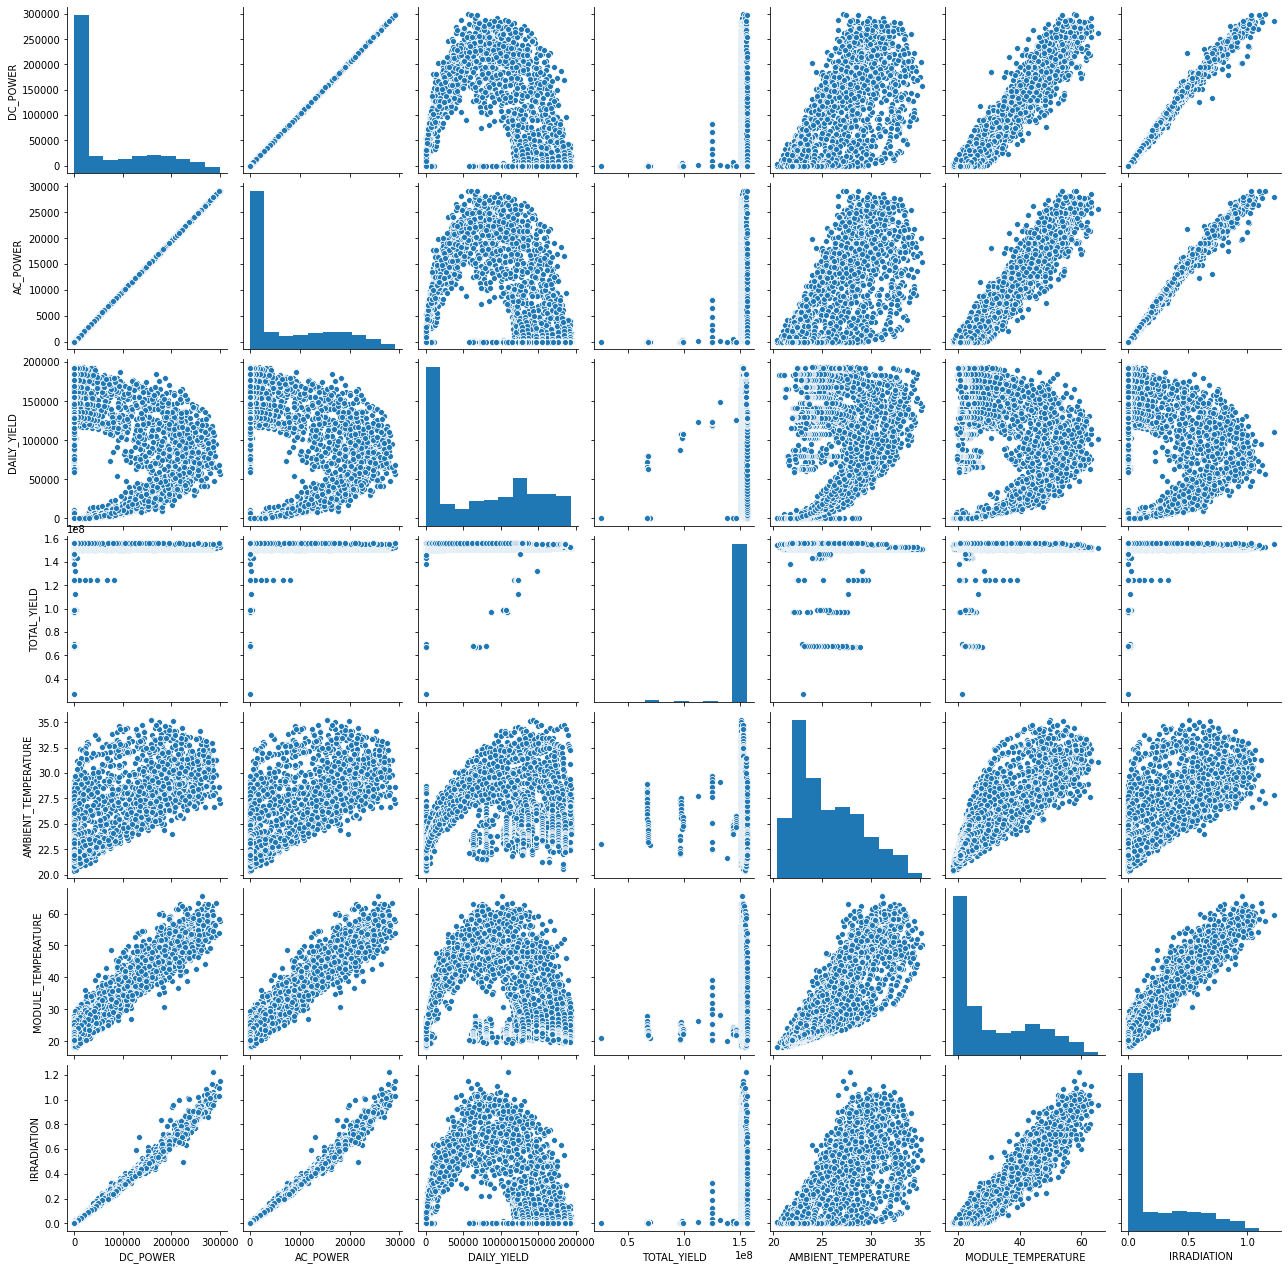

time: 9.98 s (started: 2022-03-04 13:24:15 +01:00)


In [305]:
# merged_df = pd.merge(gen_data.groupby(gen_data.index.date).sum(), weather_data.groupby(weather_data.index.date).sum(), left_on=gen_data.groupby(gen_data.index.date).sum().index, right_on=weather_data.groupby(weather_data.index.date).sum().index)
merged_df = pd.merge(gen_data.groupby(gen_data.index).sum(), weather_data, left_on=gen_data.groupby(gen_data.index).sum().index, right_on=weather_data.index)
sns.pairplot(merged_df)
plt.show()

Text(0, 0.5, 'irradiation')

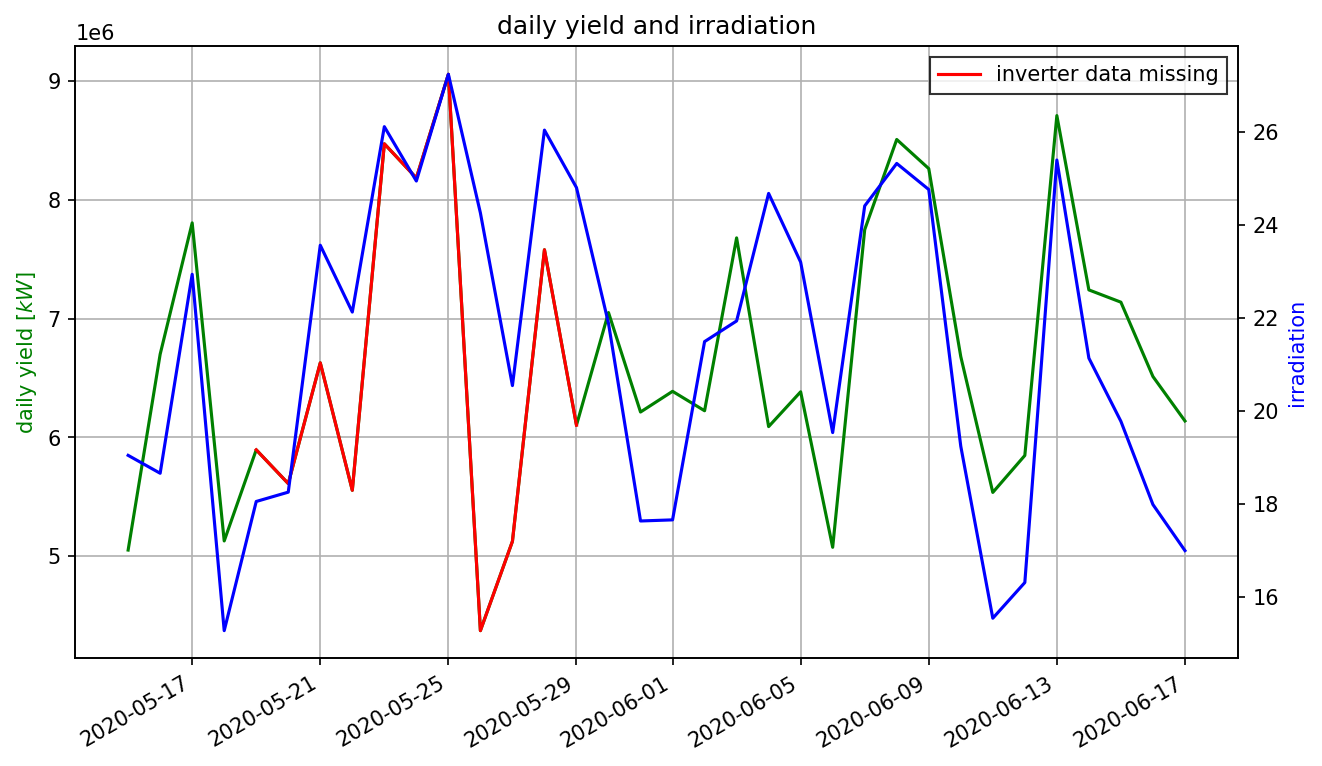

time: 1.01 s (started: 2022-03-04 13:24:25 +01:00)


In [306]:
fig,ax = plt.subplots(dpi=150,figsize=(10,6))
#gen_data.groupby(gen_data.index.date).sum().plot(y = 'DAILY_YIELD', ax = ax[0])
#gen_data.groupby(gen_data.index.date).sum().plot.bar(y = 'TOTAL_YIELD', ax = ax[1]) 

plt.ioff()
plt.grid()
fig.autofmt_xdate()
ax.plot(gen_data.groupby(gen_data.index.date).sum()['DAILY_YIELD'], color="g")
ax.plot(gen_data.groupby(gen_data.index.date).sum()['DAILY_YIELD'][4:15], label="inverter data missing", color="r")
ax.set_ylabel(f'daily yield $[kW]$', color="g")
ax.legend(loc='upper right', shadow=False, fancybox=False, facecolor='white', edgecolor='black')
ax.set_title("daily yield and irradiation")
ax2=ax.twinx()
#ax2.plot(gen_data.groupby(gen_data.index.date).sum()['AC_POWER'], color="g")
ax2.plot(weather_data.groupby(weather_data.index.date).sum().index, weather_data.groupby(weather_data.index.date).sum()['IRRADIATION'], label="irradiation", color="b")
ax2.set_ylabel("irradiation",color="b")


<AxesSubplot:>

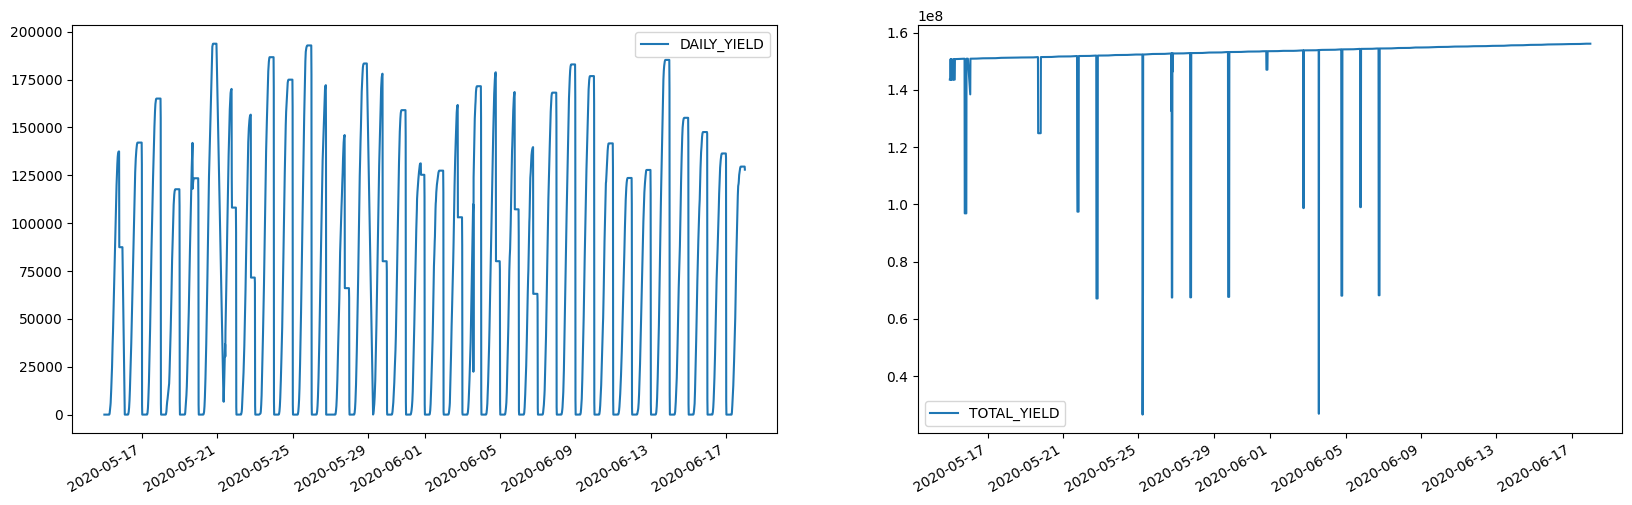

time: 938 ms (started: 2022-03-04 13:24:52 +01:00)


In [309]:
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
gen_data.groupby(gen_data.index).sum().plot(y = 'DAILY_YIELD', ax = ax[0])
gen_data.groupby(gen_data.index).sum().plot(y = 'TOTAL_YIELD', ax = ax[1]) 

In [308]:
# gen_data_forecast = gen_data.groupby(gen_data.index).sum()
# gen_data_forecast

time: 0 ns (started: 2022-03-04 13:24:29 +01:00)
